## Conv2D

In [1]:
import autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
# Check if GPU is available
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [3]:
import sys
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
sys.path.append('../src')

import tensorflow as tf
from data_processing.mtb_data_provider import MtbDataProvider
from visualization.visualize import MtbVisualizer
from models.conv1d_model import Conv1dModel
from models.conv2d_model import Conv2dModel
from tensorflow.keras.callbacks import ModelCheckpoint

In [7]:
WINDOW_SIZE = 5000 # in milliseconds
KERNEL_LENGTH = 10 #in sample data points
KERNEL_HEIGHT = 2
FREQUENCY = 40 # in milliseconds
SAMPLE_SIZE = WINDOW_SIZE // FREQUENCY
print("SAMPLE_SIZE =", SAMPLE_SIZE)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.set_random_seed(RANDOM_SEED)

SAMPLE_SIZE = 125


### Prepare data

<img src="img/input_shape.png" alt="Drawing" style="width: 600px;"/>

#### Conv2d, multiple Sensors and multiple sessions

In [5]:
RAW_FILES = ['neureuth'] # Multiple Sessions ['neureuth', 'anothersession']
VAL_FILE = 'neureuth'

In [6]:
def load_data():
    X_result = None
    y_result = None
    for raw_file in RAW_FILES:
        X_tmp, y_tmp = MtbDataProvider.load_data('../data/raw/' + raw_file, '*?[0-9].csv', frequency=FREQUENCY)
        X_tmp = MtbDataProvider.sync_sensors(X_tmp)
        X_tmp, y_tmp = MtbDataProvider.slice_sensors(X_tmp, y_tmp, window_size=WINDOW_SIZE, frequency=FREQUENCY, step_size=.25)

        if X_result is None:
            X_result = X_tmp
            y_result = y_tmp
        else:
            X_result = np.concatenate((X_result, X_tmp))
            y_result = np.concatenate((y_result, y_tmp))

    return X_result, y_result
X, y = load_data()

reading  ../data/raw/neureuth_acc_2.csv
reading  ../data/raw/neureuth_acc_1.csv
reading  ../data/raw/neureuth_gyr_2.csv
reading  ../data/raw/neureuth_gyr_1.csv


In [26]:
# IF THERE IS NO VALIDATION SESSION (yet), split 80/20
# Do not run this multiple times in a row, because it overwrites X_train and therefore will get smaller and smaller

from sklearn.model_selection import train_test_split
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=.1, random_state=RANDOM_SEED, shuffle=True)

In [8]:
print(X_train.shape, y_train.shape)
print(X_dev.shape, y_dev.shape)

(868, 150, 4, 3) (868,)
(97, 150, 4, 3) (97,)


## Evaluation

### Conv2D, Multiple Sensors

In [9]:
model_cnn2 = Conv2dModel.build_model(input_shape=X_train[0].shape, 
                                     cnn_blocks=3,
                                     dropout=0.3,
                                     kernel_size=(KERNEL_LENGTH, KERNEL_HEIGHT))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
model_cnn2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 4, 3)         183       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 150, 4, 3)         12        
_________________________________________________________________
activation (Activation)      (None, 150, 4, 3)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 4, 3)          0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 4, 3)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 4, 8)          488       
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 75, 4, 8)          32        
__________

In [31]:
filepath="../checkpoints/conv2d-" + str(WINDOW_SIZE) + "-" + str(KERNEL_LENGTH) + "-{epoch:02d}-{val_sparse_categorical_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, save_best_only = True, monitor='val_sparse_categorical_accuracy', mode='max')
model_cnn2.fit(X_train, y_train,
              epochs=300,
              batch_size=16,
              validation_data=(X_dev, y_dev), 
              callbacks = [checkpoint])

Train on 868 samples, validate on 97 samples
Epoch 1/300
868/868 [==============================] - 1s 637us/sample - loss: 0.3190 - sparse_categorical_accuracy: 0.9078 - val_loss: 1.0736 - val_sparse_categorical_accuracy: 0.6804
Epoch 2/300
868/868 [==============================] - 1s 660us/sample - loss: 0.3106 - sparse_categorical_accuracy: 0.8998 - val_loss: 0.9992 - val_sparse_categorical_accuracy: 0.6907
Epoch 3/300
868/868 [==============================] - 1s 584us/sample - loss: 0.3400 - sparse_categorical_accuracy: 0.9055 - val_loss: 1.0359 - val_sparse_categorical_accuracy: 0.6907
Epoch 4/300
868/868 [==============================] - 1s 578us/sample - loss: 0.3286 - sparse_categorical_accuracy: 0.9009 - val_loss: 1.0404 - val_sparse_categorical_accuracy: 0.6907
Epoch 5/300
868/868 [==============================] - 1s 639us/sample - loss: 0.3455 - sparse_categorical_accuracy: 0.8906 - val_loss: 0.9315 - val_sparse_categorical_accuracy: 0.7320
Epoch 6/300
868/868 [=========

Epoch 45/300
868/868 [==============================] - 0s 574us/sample - loss: 0.3144 - sparse_categorical_accuracy: 0.9009 - val_loss: 1.0925 - val_sparse_categorical_accuracy: 0.6701
Epoch 46/300
868/868 [==============================] - 0s 559us/sample - loss: 0.3059 - sparse_categorical_accuracy: 0.9067 - val_loss: 1.0217 - val_sparse_categorical_accuracy: 0.7010
Epoch 47/300
868/868 [==============================] - 0s 575us/sample - loss: 0.3317 - sparse_categorical_accuracy: 0.8975 - val_loss: 1.0719 - val_sparse_categorical_accuracy: 0.6907
Epoch 48/300
868/868 [==============================] - 1s 605us/sample - loss: 0.2988 - sparse_categorical_accuracy: 0.9147 - val_loss: 1.0049 - val_sparse_categorical_accuracy: 0.7216
Epoch 49/300
868/868 [==============================] - 1s 578us/sample - loss: 0.3038 - sparse_categorical_accuracy: 0.9101 - val_loss: 1.1780 - val_sparse_categorical_accuracy: 0.6701
Epoch 50/300
868/868 [==============================] - 0s 576us/sampl

868/868 [==============================] - 0s 571us/sample - loss: 0.3011 - sparse_categorical_accuracy: 0.8952 - val_loss: 1.1630 - val_sparse_categorical_accuracy: 0.6907
Epoch 90/300
868/868 [==============================] - 1s 599us/sample - loss: 0.2920 - sparse_categorical_accuracy: 0.9147 - val_loss: 1.0284 - val_sparse_categorical_accuracy: 0.6804
Epoch 91/300
868/868 [==============================] - 1s 578us/sample - loss: 0.2760 - sparse_categorical_accuracy: 0.9078 - val_loss: 1.2201 - val_sparse_categorical_accuracy: 0.6907
Epoch 92/300
868/868 [==============================] - 1s 601us/sample - loss: 0.3107 - sparse_categorical_accuracy: 0.9136 - val_loss: 1.1191 - val_sparse_categorical_accuracy: 0.6907
Epoch 93/300
868/868 [==============================] - 1s 592us/sample - loss: 0.2625 - sparse_categorical_accuracy: 0.9055 - val_loss: 1.2299 - val_sparse_categorical_accuracy: 0.6907
Epoch 94/300
868/868 [==============================] - 0s 553us/sample - loss: 0.2

Epoch 133/300
868/868 [==============================] - 0s 571us/sample - loss: 0.3085 - sparse_categorical_accuracy: 0.9147 - val_loss: 1.2295 - val_sparse_categorical_accuracy: 0.7010
Epoch 134/300
868/868 [==============================] - 0s 571us/sample - loss: 0.2738 - sparse_categorical_accuracy: 0.9194 - val_loss: 1.0689 - val_sparse_categorical_accuracy: 0.7113
Epoch 135/300
868/868 [==============================] - 1s 608us/sample - loss: 0.2750 - sparse_categorical_accuracy: 0.9182 - val_loss: 1.0903 - val_sparse_categorical_accuracy: 0.6907
Epoch 136/300
868/868 [==============================] - 0s 564us/sample - loss: 0.2711 - sparse_categorical_accuracy: 0.9124 - val_loss: 1.2613 - val_sparse_categorical_accuracy: 0.6701
Epoch 137/300
868/868 [==============================] - 1s 589us/sample - loss: 0.3173 - sparse_categorical_accuracy: 0.9055 - val_loss: 1.1063 - val_sparse_categorical_accuracy: 0.6804
Epoch 138/300
868/868 [==============================] - 0s 566us

Epoch 177/300
868/868 [==============================] - 1s 595us/sample - loss: 0.2420 - sparse_categorical_accuracy: 0.9263 - val_loss: 1.0431 - val_sparse_categorical_accuracy: 0.7732
Epoch 178/300
868/868 [==============================] - 1s 583us/sample - loss: 0.2858 - sparse_categorical_accuracy: 0.9147 - val_loss: 1.0556 - val_sparse_categorical_accuracy: 0.7010
Epoch 179/300
868/868 [==============================] - 1s 589us/sample - loss: 0.2928 - sparse_categorical_accuracy: 0.9124 - val_loss: 1.1610 - val_sparse_categorical_accuracy: 0.7113
Epoch 180/300
868/868 [==============================] - 1s 583us/sample - loss: 0.2736 - sparse_categorical_accuracy: 0.9240 - val_loss: 1.0753 - val_sparse_categorical_accuracy: 0.6701
Epoch 181/300
868/868 [==============================] - 1s 581us/sample - loss: 0.2915 - sparse_categorical_accuracy: 0.9124 - val_loss: 0.8900 - val_sparse_categorical_accuracy: 0.7732
Epoch 182/300
868/868 [==============================] - 1s 581us

Epoch 221/300
868/868 [==============================] - 1s 589us/sample - loss: 0.2319 - sparse_categorical_accuracy: 0.9332 - val_loss: 1.0633 - val_sparse_categorical_accuracy: 0.7423
Epoch 222/300
868/868 [==============================] - 1s 591us/sample - loss: 0.2459 - sparse_categorical_accuracy: 0.9240 - val_loss: 1.0284 - val_sparse_categorical_accuracy: 0.7526
Epoch 223/300
868/868 [==============================] - 0s 571us/sample - loss: 0.2845 - sparse_categorical_accuracy: 0.9159 - val_loss: 1.0330 - val_sparse_categorical_accuracy: 0.7216
Epoch 224/300
868/868 [==============================] - 1s 588us/sample - loss: 0.2516 - sparse_categorical_accuracy: 0.9286 - val_loss: 0.8953 - val_sparse_categorical_accuracy: 0.8041
Epoch 225/300
868/868 [==============================] - 1s 579us/sample - loss: 0.2326 - sparse_categorical_accuracy: 0.9424 - val_loss: 0.8807 - val_sparse_categorical_accuracy: 0.8041
Epoch 226/300
868/868 [==============================] - 1s 579us

Epoch 265/300
868/868 [==============================] - 0s 572us/sample - loss: 0.2284 - sparse_categorical_accuracy: 0.9401 - val_loss: 1.0184 - val_sparse_categorical_accuracy: 0.7423
Epoch 266/300
868/868 [==============================] - 1s 591us/sample - loss: 0.2537 - sparse_categorical_accuracy: 0.9297 - val_loss: 0.9596 - val_sparse_categorical_accuracy: 0.7629
Epoch 267/300
868/868 [==============================] - 0s 575us/sample - loss: 0.2382 - sparse_categorical_accuracy: 0.9343 - val_loss: 1.0706 - val_sparse_categorical_accuracy: 0.7216
Epoch 268/300
868/868 [==============================] - 1s 615us/sample - loss: 0.2456 - sparse_categorical_accuracy: 0.9286 - val_loss: 1.0791 - val_sparse_categorical_accuracy: 0.6907
Epoch 269/300
868/868 [==============================] - 1s 586us/sample - loss: 0.2187 - sparse_categorical_accuracy: 0.9389 - val_loss: 0.8678 - val_sparse_categorical_accuracy: 0.7835
Epoch 270/300
868/868 [==============================] - 0s 574us

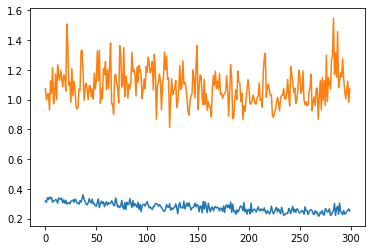

In [43]:
plt.plot(model_cnn2.history.history['loss'])
plt.plot(model_cnn2.history.history['val_loss'])
plt.show()

## Evaluation

* 0 = blue = easy
* 1 = red = medium
* 2 = black = hard
* 3 = white = not riding

### Predicted results

In [33]:
y_pred_dev = model_cnn2.predict(X_dev)
y_pred_dev = np.argmax(y_pred_dev, axis=1)

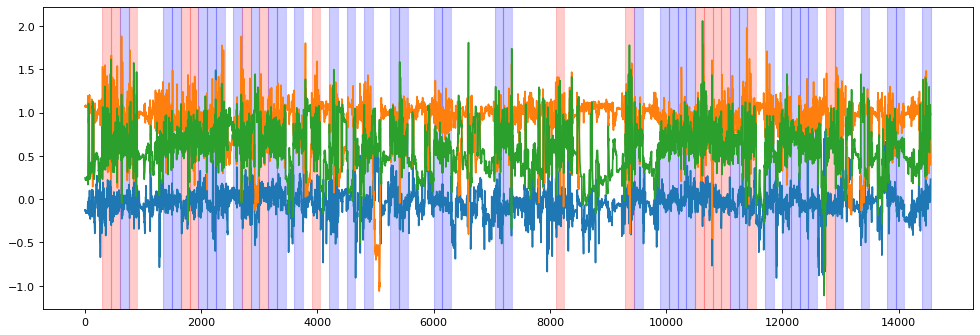

In [34]:
# This only plots the first sensor
X_dev_plot = X_dev if len(X_dev.shape) <= 3 else X_dev[:,:,0]
MtbVisualizer.plot_results(X_dev_plot, y_pred_dev, SAMPLE_SIZE)

### True results

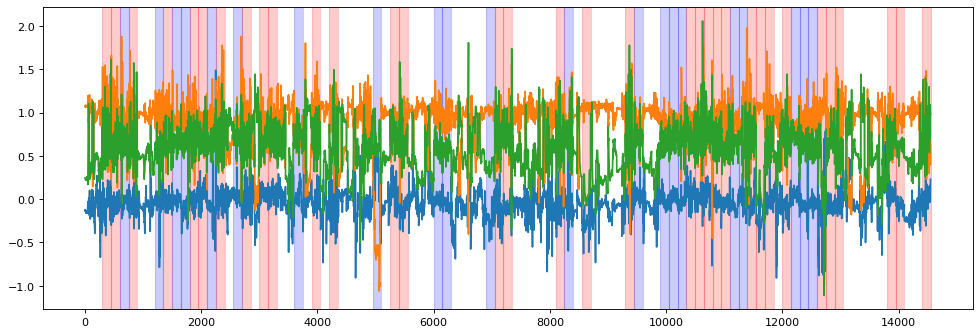

In [35]:
MtbVisualizer.plot_results(X_dev_plot, y_dev, SAMPLE_SIZE)

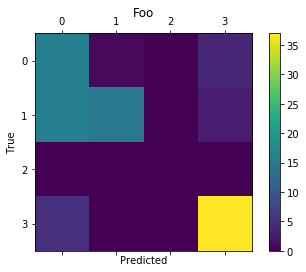

In [36]:
MtbVisualizer.print_confusion_matrix(y_dev, y_pred_dev, labels=[0,1,2,3])

### Test on Train data

In [37]:
y_pred = model_cnn2.predict(X)
y_pred = np.argmax(y_pred, axis=1)

### Predicted results

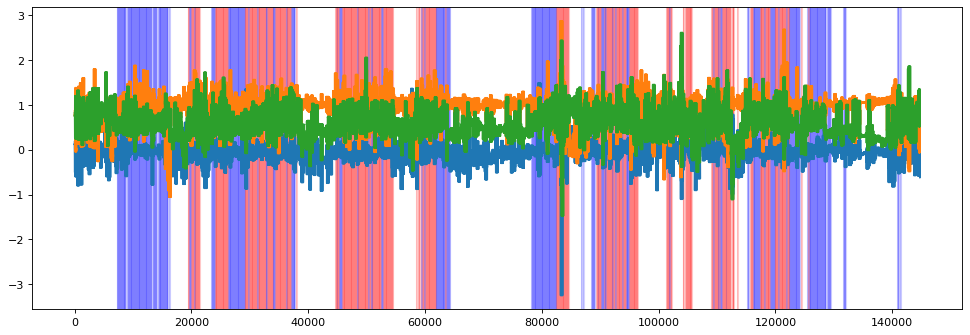

In [38]:
X_plot = X[:,:,0]
MtbVisualizer.plot_results(X_plot, y_pred, SAMPLE_SIZE)

### True results

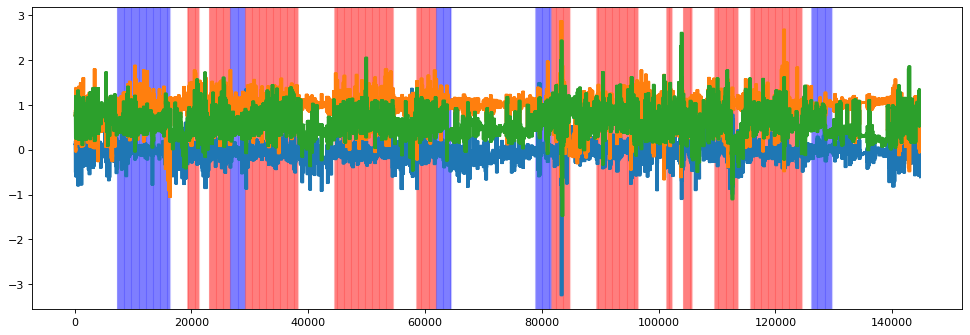

In [39]:
X_plot = X[:,:,0]
MtbVisualizer.plot_results(X_plot, y, SAMPLE_SIZE)

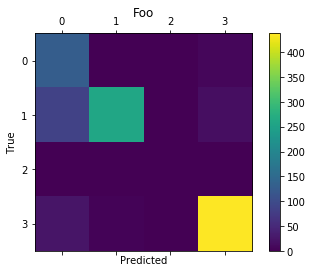

In [40]:
MtbVisualizer.print_confusion_matrix(y, y_pred, labels=[0,1,2,3])

## Explore per sensor

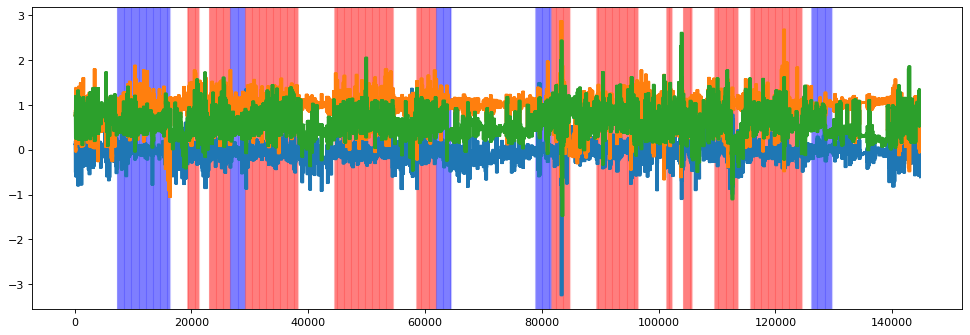

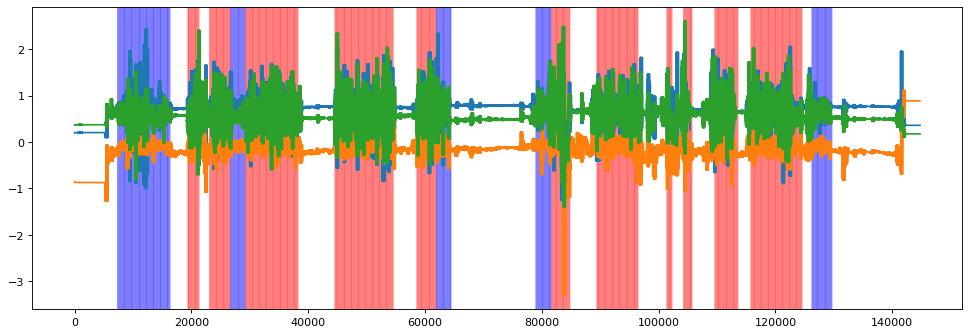

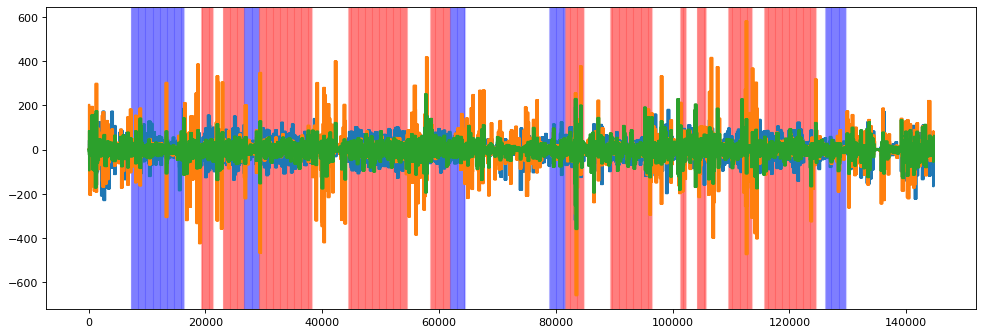

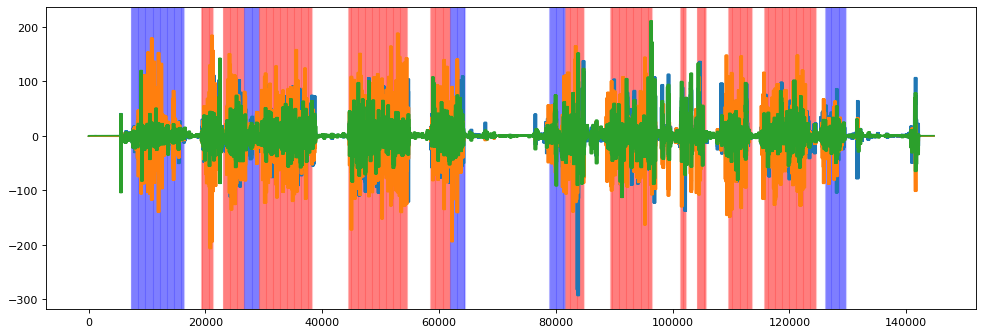

In [41]:
for i in range(0, X_train.shape[2]):
    X_plot = X_train if len(X.shape) <= 3 else X[:,:,i]
    MtbVisualizer.plot_results(X_plot, y, SAMPLE_SIZE)#[205:220]